###Start###

This version is the most normal version of all versions. In this version unitary initialization used but BN and L2 have been removed from architecture of the model. additionally unitary weights are freezed and not trainable.


In [ ]:
import tensorflow as tf
import numpy as np
import os, random
import matplotlib.pyplot as plt
from keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import classification_report
import time
import psutil


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/tf_HH/NP_data/'
trainImages = np.load(path + 'trainImages.npy')
trainLabels = np.load(path + 'trainLabels.npy')
testImages  = np.load(path + 'testImages.npy')
testLabels  = np.load(path + 'testLabels.npy')

In [ ]:

augmented = ImageDataGenerator(rotation_range=12,
                               width_shift_range = 0.1,
                               height_shift_range= 0.1,
                               zoom_range=0.1,
                               horizontal_flip= True)
augmented.fit(trainImages)
augmented.fit(testImages)

###Data Check

(1000, 256, 256, 3)   float32
(1000, 2)
(256, 256, 256, 3)
(256, 2)


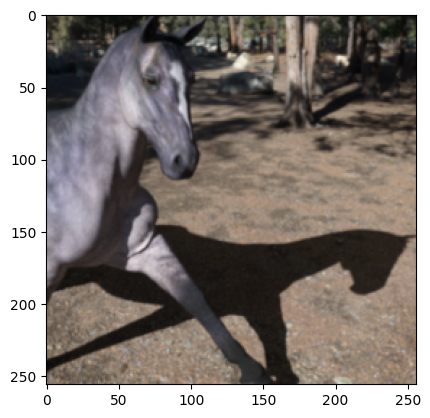

In [ ]:
#Data Loading Check
plt.imshow(trainImages[254])
print(trainImages.shape, " ", trainImages.dtype)
print(trainLabels.shape)
print(testImages.shape)
print(testLabels.shape)

In [ ]:
\
classes = ['AD', 'CN']

figure, axes = plt.subplots(4, 5, figsize= (12,12))
for i in range(len(trainImages)):
  if trainLabels[i][0] == 1 :
    titleIndex = 0
  else :
    titleIndex = 1
  ax_row = i // 5
  ax_col = i % 5
  if ax_row ==4 or ax_col==5:
    break
  ax = axes[ax_row][ax_col]
  ax.imshow(trainImages[i])
  ax.set_title(classes[titleIndex])
  ax.axis('off')

plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

###Unitary Regularizer###


In [ ]:
# used version 1.2
import tensorflow.keras.backend as K
class UnitaryRegularizer(tf.keras.regularizers.Regularizer):
    def __init__(self, lambd):
        self.lambd = lambd

    def __call__(self, weights):
        # Get the number of output neurons
        num_output_neurons = weights.shape[-1]

        # Reshape the weight matrix to be a 2D matrix (flatten filters)
        flattened_weights = tf.reshape(weights, (-1, num_output_neurons))

        # Calculate the matrix product and the identity matrix
        product = tf.matmul(flattened_weights, tf.transpose(flattened_weights))
        identity_matrix = tf.eye(product.shape[0])

        # Calculate the Frobenius norm for each filter separately
        filter_norms = tf.norm(product - identity_matrix, axis=[-2, -1])
        #print(filter_norms)

        # Calculate the regularization term as the sum of squared Frobenius norms
        regularization = 0.5 * self.lambd * tf.reduce_sum(tf.square(filter_norms))
        #tf.print(regularization)
        return regularization

    def get_config(self):
        return {'lambd': self.lambd}

###MODEL

In [ ]:
my_resnet = tf.keras.applications.ResNet50(input_shape=(256, 256, 3), include_top=False)
my_resnet.trainable = False
custom_lambd = 0.01
model = tf.keras.Sequential([
    tf.keras.layers.Input((256, 256, 3)),
    tf.keras.layers.BatchNormalization(),
    my_resnet,
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 256, kernel_size = (3, 3),
                             activation = tf.nn.
                           relu , name='conv1', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool1'),
    tf.keras.layers.Conv2D(filters = 128, kernel_size = (3, 3),
                             activation = tf.nn.relu, padding='same',
                            name='conv2',
                           kernel_regularizer= UnitaryRegularizer(lambd=custom_lambd) ),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = (3, 3),
                             activation = tf.nn.relu, name='conv3',
                            padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), name='pool3'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                           activation= tf.nn.relu, padding='same',
                           name='conv4',
                           kernel_regularizer= UnitaryRegularizer(lambd=custom_lambd) ),
    tf.keras.layers.Conv2D(filters = 32, kernel_size = (3, 3),
                           activation= tf.nn.relu, padding='same',
                           name='conv5',
                           kernel_regularizer= UnitaryRegularizer(lambd=custom_lambd) ),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = tf.nn.relu),
    tf.keras.layers.Dense(64, activation = tf.nn.relu),
                          #kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.Dense(2, activation = 'sigmoid')
])

94765736/94765736 [==============================] - 1s 0us/step


###Unitary Initialization###

In [ ]:
# this function below is utilizing CPU because of using NUMPY
def unitarizer(weightArr):
  unitaryMatrices = np.empty_like(weightArr)
  print("1")
  weightArr_tr = np.transpose(weightArr, (3, 2, 0, 1))
  print("2 tr: ", weightArr_tr.shape)
  U, SIGMA, V_trans = np.linalg.svd(weightArr_tr)
  print("3 ", V_trans.shape)
  W = V_trans.T
  print("4 ", W.shape)
  W = np.reshape(W, weightArr.shape)
  print("5")
  #unitaryMatrices[:,:,i,j] = unitarySingleKernel
  return W

In [ ]:
trainableWeights = model.trainable_weights
print("the shape of trainable weights in first conv", trainableWeights[14].shape)

the shape of trainable weights in first conv (3, 3, 64, 32)


In [ ]:
indecies = [8, 14, 16]

for idx in indecies:
  print("***********************  Convolution is unitarizing ", idx, " ************************")
  convWeights  = trainableWeights[idx]
  print(convWeights.shape)
  U_convWeights = unitarizer(convWeights)
  print(U_convWeights[0][0][16][16])
  print("*************************  Convolution unitarized ", idx, "  *************************")
  model.trainable_weights[idx].assign(U_convWeights)
  convtester = model.trainable_weights[idx]
  print("************************* Convolution unitaryCheck ", idx, " *************************")
  print(convtester[0][0][16][16])






***********************  Convolution is unitarizing  8  ************************
(3, 3, 256, 128)
1
2 tr:  (128, 256, 3, 3)
3  (128, 256, 3, 3)
4  (3, 3, 256, 128)
5
-0.52638793
*************************  Convolution unitarized  8   *************************
************************* Convolution unitaryCheck  8  *************************
tf.Tensor(-0.52638793, shape=(), dtype=float32)
***********************  Convolution is unitarizing  14  ************************
(3, 3, 64, 32)
1
2 tr:  (32, 64, 3, 3)
3  (32, 64, 3, 3)
4  (3, 3, 64, 32)
5
-0.72543454
*************************  Convolution unitarized  14   *************************
************************* Convolution unitaryCheck  14  *************************
tf.Tensor(-0.72543454, shape=(), dtype=float32)
***********************  Convolution is unitarizing  16  ************************
(3, 3, 32, 32)
1
2 tr:  (32, 32, 3, 3)
3  (32, 32, 3, 3)
4  (3, 3, 32, 32)
5
-0.6808989
*************************  Convolution unitarized  16   ***

In [ ]:
#not needed when we regularize it.
#model.layers[4].trainable=False
#model.layers[8].trainable=False
#model.layers[9].trainable=False

###Model compile###

In [ ]:
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
checkpointPath = "/content/drive/MyDrive/Kag-adni-unBalance/finalCheckPoints/FinalRuns3/"

checkPointCallBack = ModelCheckpoint(filepath = checkpointPath,
                                     monitor = 'val_accuracy',
                                     mode='max', save_best_only = True)


###Model Check

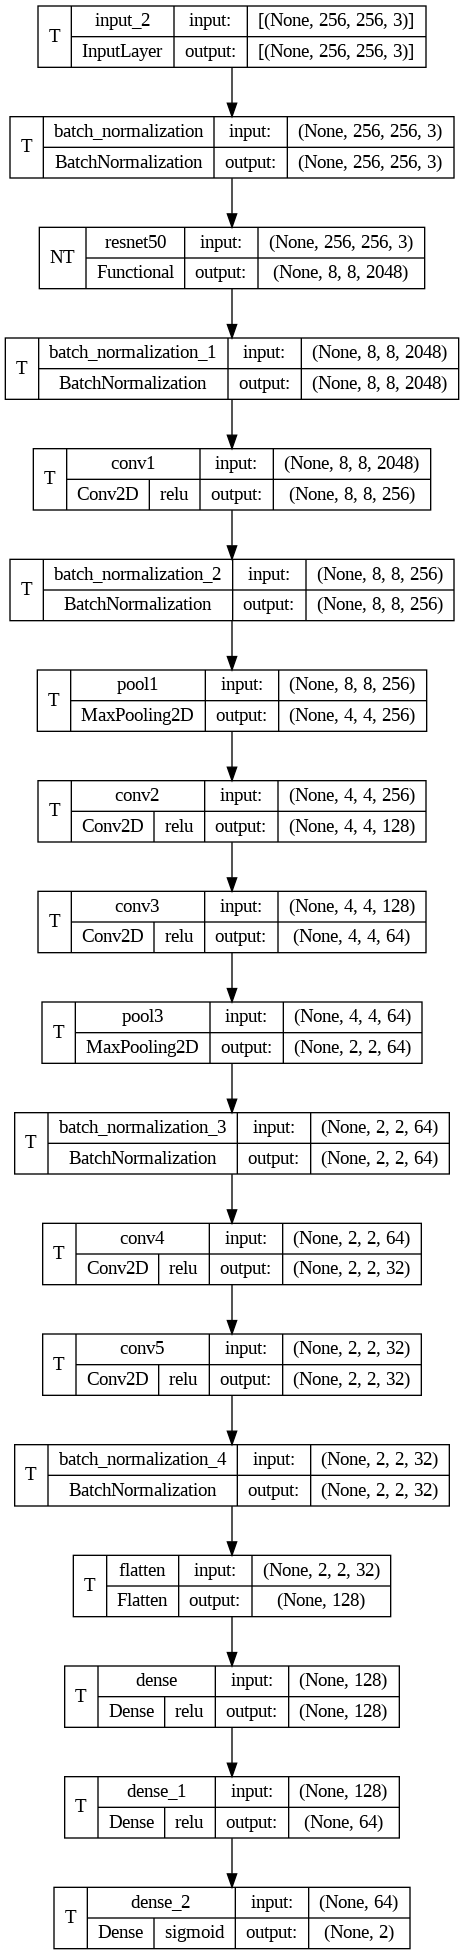

In [ ]:
tf.keras.utils.plot_model(model, show_shapes = True,
                          show_layer_activations=True, show_trainable= True)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 256, 256, 3)      12        
 ormalization)                                                   
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 batch_normalization_1 (Batc  (None, 8, 8, 2048)       8192      
 hNormalization)                                                 
                                                                 
 conv1 (Conv2D)              (None, 8, 8, 256)         4718848   
                                                                 
 batch_normalization_2 (Batc  (None, 8, 8, 256)        1024      
 hNormalization)                                                 
                                                        

###RUN###

In [ ]:
training_times = []
memory_usage = []
testAccuracy = []
num_epochs = 120
for epoch in range(num_epochs):
  startTime = time.time()
  history = model.fit(augmented.flow(trainImages, trainLabels, batch_size = 64),
                    epochs = 1)
          #validation_data=(testImages, testLabels))
                    #callbacks=[checkPointCallBack])#with version 1.2
  endTime = time.time()
  epochTime = endTime - startTime
  training_times.append(epochTime)
  memory_usage.append(psutil.virtual_memory().used/1024**2)
  testLoss , testAcc = model.evaluate(testImages, testLabels, verbose = 0)
  testAccuracy.append(testAcc)
  print(f"Epoch {epoch + 1}/{num_epochs} - Time: {epochTime:.2f}s - Memory Usage: {memory_usage[-1]:.2f}MB - val_loss: {testLoss} - val_accuracy: {testAcc}")
  print("*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*")

16/16 [==============================] - 43s 1s/step - loss: 69045.9062 - accuracy: 0.6680
Epoch 1/120 - Time: 43.61s - Memory Usage: 5604.29MB - val_loss: 10736.9208984375 - val_accuracy: 0.5
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
16/16 [==============================] - 18s 1s/step - loss: 6310.4424 - accuracy: 0.8410
Epoch 2/120 - Time: 21.29s - Memory Usage: 5853.93MB - val_loss: 3567.158935546875 - val_accuracy: 0.7734375
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
16/16 [==============================] - 19s 1s/step - loss: 2560.6018 - accuracy: 0.8930
Epoch 3/120 - Time: 22.49s - Memory Usage: 6029.71MB - val_loss: 1789.7186279296875 - val_accuracy: 0.82421875
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
16/16 [==============================] - 20s 1s/step - loss: 1406.7737 - accuracy: 0.9210
Epoch 4/120 - Time: 21.54s - Memory Usage: 6149.90MB - val_loss: 1079.717529296875 - val_accuracy: 0.8671875
*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*
16/16 [==============================] - 18s 1s/

###Metrics Evaluation###


In [ ]:
predictedLabels = model.predict(testImages)
predictedClasses = np.argmax(predictedLabels, axis = 1)

report = classification_report(testLabels.argmax(axis = 1), predictedClasses)
print(report)


8/8 [==============================] - 2s 109ms/step
              precision    recall  f1-score   support

           0       0.80      0.88      0.84       128
           1       0.87      0.77      0.82       128

    accuracy                           0.83       256
   macro avg       0.83      0.83      0.83       256
weighted avg       0.83      0.83      0.83       256



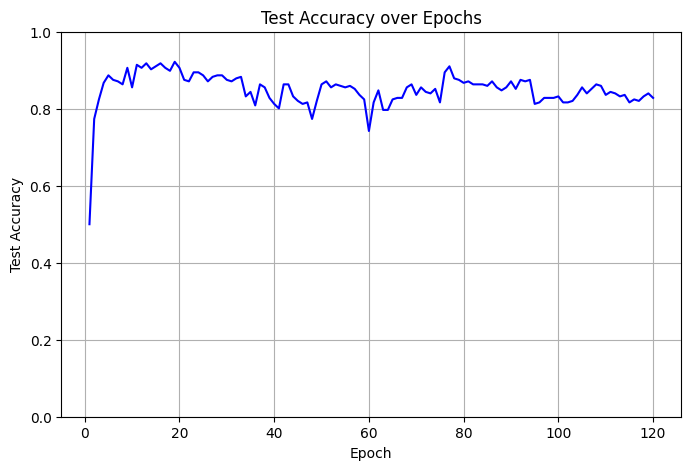

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, num_epochs + 1), testAccuracy, color='b')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy over Epochs')
plt.ylim([0, 1])  # Set y-axis limit between 0 and 1
plt.grid(True)
plt.show()

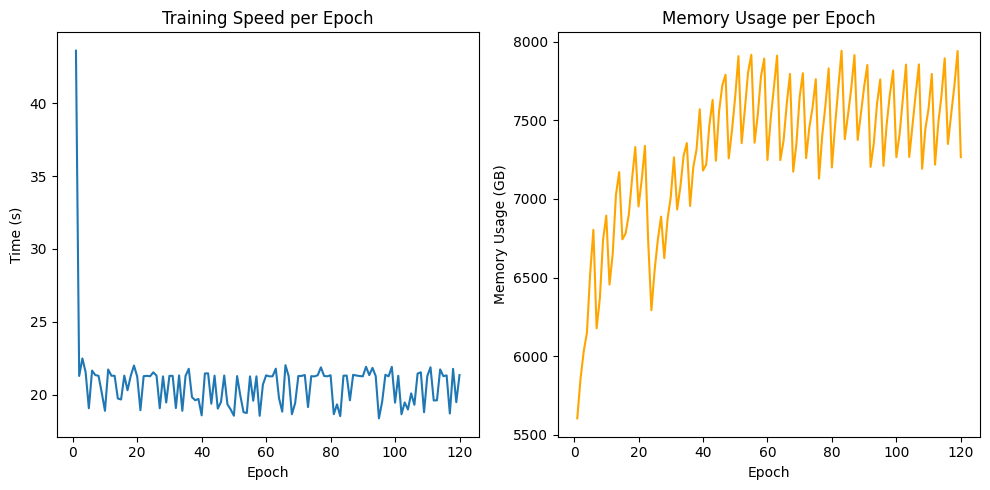

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), training_times)
plt.xlabel('Epoch')
plt.ylabel('Time (s)')
plt.title('Training Speed per Epoch')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), memory_usage, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Memory Usage (GB)')
plt.title('Memory Usage per Epoch')

plt.tight_layout()
plt.show()